# Focus on priors


## Chosing the prior distribution

In the doctor example, if the doctor we go to has access to patient's history, but only from when the patient was a child and not for their recent years as an adult, they might make the wrong inference about the current cause of a headache. For example, if they don't know that the patient was in a car accident last month and banged their head, they could get the cause of the headache very wrong. 

The choice of prior is really important! Restricting the range of potential prior distributions to a particular family is frequently beneficial and justifiable. The choice of this family can be based on the type of likelihood function. We will discuss such a choice in the section on [conjugate priors](conjugate_priors).
Whether we actually know anything about a parameter or not can be expressed via [informative an uninformative priors](informative_uninformative_priors).

(conjugate_priors)=
## Conjugate priors

A prior distribution $p(\theta)$ is said to be <span style="color:orange">conjugate</span> to a likelihood function $p(y|\theta)$ if the posterior distribution $p(\theta|y)$ has the same functional form as the prior distribution, i.e. this is the situation when the prior and posterior are from the same family. The use of conjugate priors for the likelihood produces posterior distributions in a closed form, then makes it possible to solve the posterior analytically.

For any likelihood function of the exponential family, a conjugate prior distribution always exists. That is the reason of the importance of the exponential family distributions, that in simple models and with the use of conjugate priors, the posterior has analytic solution, which is known as the conjugate-exponential model.


(informative_uninformative_priors)=
## Informative and uninformative priors


<span style="color:orange">Informative priors</span> convey substantial information about the parameters before observing the data. They are typically chosen based on existing knowledge, previous studies, or expert opinions. They expresses specific, definite information about a variable.

<span style="color:orange">Non-Informative priors</span> express minimal prior information about the parameters. They are often chosen to allow the data to dominate the inference process. They are desirable when little prior knowledge or subjective information is available. Common choices for non-informative priors include uniform distributions or [Jeffrey's priors](jeffreys_priors), which distribute prior probability equally over a parameter space. They expresses vague or general information about a variable. 

(jeffreys_priors)=
## Jeffrey's priors

Jeffrey's priors are non-informative prior distributions, named after Harold Jeffreys. They are chosen to maximize information entropy under certain constraints, such as <span style="color:orange">invariance under reparameterization</span>. For continuous parameters, Jeffrey's prior is proportional to the square root of the determinant of the Fisher information matrix. These priors encode minimal prior information, allowing the data to dominate the inference process.

For example, in the case of a continuous parameter, Jeffrey's prior is proportional to the square root of the Fisher information maxtrix
```{margin}
$I(\theta) = - \frac{d^2l(\theta)}{d \theta^2} = -\frac{dS(\theta)}{d\theta}$.
Here $\frac{dS(\theta)}{d\theta}$ is the <span style="color:orange">score function</span>.
```
$$
p(\theta) \propto \sqrt{|I(\theta)|}.
$$

 


## The influence of priors

Let us explore how much priors  can actually influence the posterior. Since tha marginal distribution $p(y)$ does not depend on the parameters, we will only explore the posterior up the to proportionality term.

$$p(\theta |y ) ∝ p(y| \theta) p(\theta).$$

If we have access to point-wise evaluations of the ikelihood $p(y | \theta)$ and prior $p(\theta)$, we can compute their product in a point-wise manner to obtain the posterior.

Consider the coin tossing problem where we midel the number of success with the Binomial distribution.

Let's say that out of $n=10$ tosses we obtained $h=6$ successes. @hat is the probability of "success" for this coin?

In [1]:
import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde


/opt/anaconda3/envs/aims/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
##############################################
# prior x likelihood = posterior
##############################################

h=6
n=9
p=h/n

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood_pmf = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

In [18]:
def computePosterior(likelihood, prior):
    # this function computes posterior
    # and plots the result

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()

    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    ax1.grid(0.3)
    plt.plot(p_grid, prior,color='purple')

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    ax2.grid(0.3)
    plt.plot(p_grid, likelihood,color='teal')

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior,color='orangered')
    ax3.grid(0.3)
    plt.show()

    return

### Prior 1 - Uniform

Our first prior will be a Uniform distribution:

$$p(\theta) = 1.$$

This means we don't think the coin is likely to be weighted or not: the probability of heads could take any value between 0 and 1 equally.

This is the same as not having a prior at all! So we should expect the likelihood and posterior distributions to look the same.

Run the code cell below to confirm your intuitions.

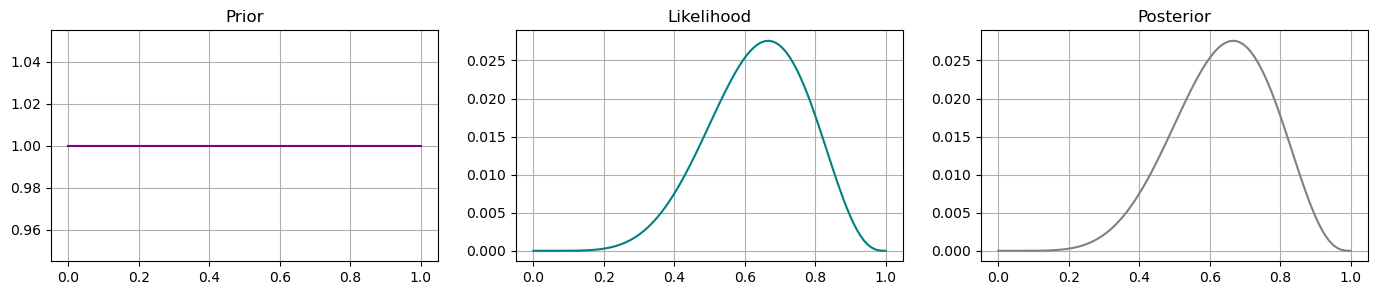

In [19]:
# Uniform prior
prior1 = jnp.repeat(1, grid_points)

# visualise prior, likelihood, posterior
posterior1 = computePosterior(likelihood_pmf, prior1)

### Prior 2 - step function

Perhaps we are pretty sure that heads is more likely than tails i.e. the coin is weighted, but we don't know by how much.

We could set this up as a step-function where the probability is 0 below a certain value, and uniform after.

$$
p(\theta) = \begin{cases}
0 \text{ if } \theta <= 0.5 \\
1 \text{ otherwise. }
\end{cases}
$$

How do you think the posterior will change? Sketch the prior to give yourself some intuition!

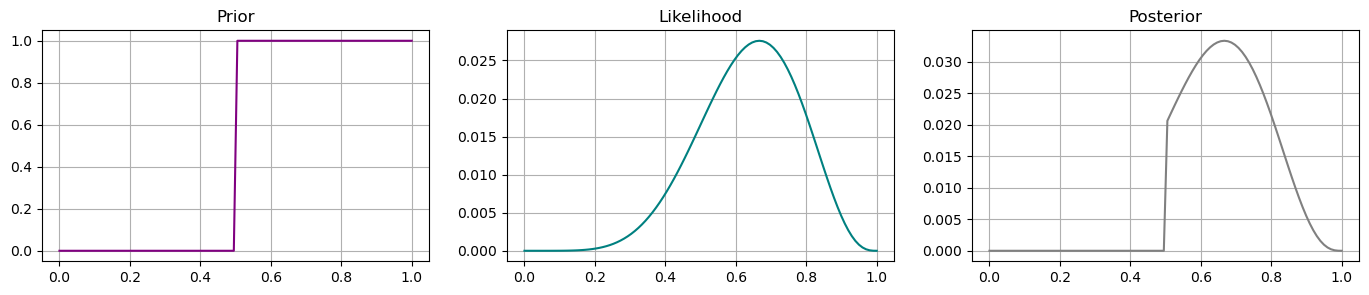

In [20]:
prior2 = (p_grid >= 0.5).astype(int)
posterior2 = computePosterior(likelihood_pmf, prior2)


### Prior 3

Let's imagine some prior that is centered at 0.5, and decays (exponentially) on either side. Run the below code and validate that this prior looks like you would expect, and shifts the likelihood to the posterior as you would expect.

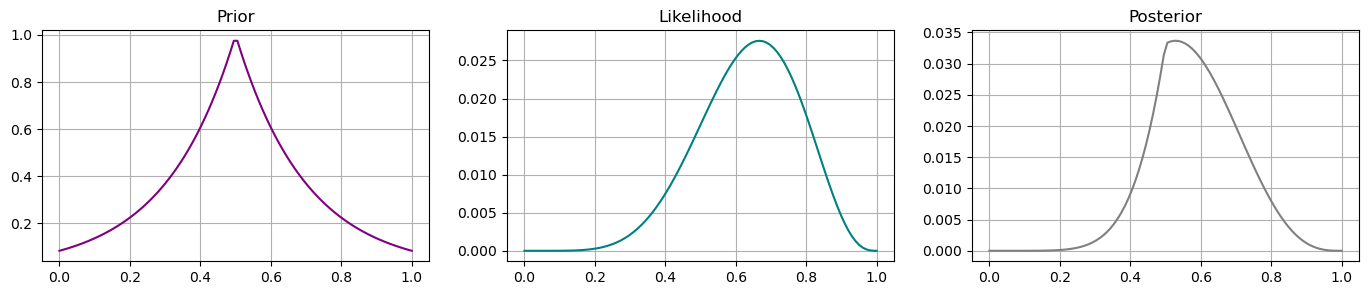

In [21]:
prior3 = jnp.exp(- 5 * abs(p_grid - 0.5))
posterior3 = computePosterior(likelihood_pmf, prior3)

`````{admonition} Task 17
:class: tip

Implement a Beta prior for this case with parameters $a,b$. How does posterior depend on these parameters?

`````

## Prior-likelihood conflict

Courtesy of Richard McEarlth: <https://twitter.com/rlmcelreath/status/1701165075493470644>

Assume we have single data point at hand 

$$
y = 0
$$ 

and would like to fit a model. 

Consider the follwoing four models:

**Model 1 (NN)**:

$$
y \sim \mathcal{N}(\mu,1), \\
\mu \sim \mathcal{N}(10,1),
$$

**Model 2 (TT)**:

$$
y \sim \text{Student}(2,\mu,1), \\
\mu \sim \text{Student}(2,10,1),
$$

**Model 3 (NT)**:

$$
y \sim \mathcal{N}(\mu,1), \\
\mu \sim \text{Student}(2,10,1),
$$

**Model 4 (TN)**:

$$
y \sim \text{Student}(2,\mu,1), \\
\mu \sim \mathcal{N}(10,1).
$$

How, do you think, posteriors from all these models will compare?



In [71]:
# Define the observed data
yobs = 0

# Define the models
def model_nn(y=None):
    mu = numpyro.sample('mu', dist.Normal(10, 1))
    numpyro.sample('y', dist.Normal(mu, 1), obs=y)

def model_tt(y=None):
    mu = numpyro.sample('mu', dist.StudentT(2, 10, 1))
    numpyro.sample('y', dist.StudentT(2, mu, 1), obs=y)

def model_nt(y=None):
    mu = numpyro.sample('mu', dist.Normal(10, 1))
    numpyro.sample('y', dist.StudentT(2, mu, 1), obs=y)

def model_tn(y=None):
    mu = numpyro.sample('mu', dist.StudentT(2, 10, 1))
    numpyro.sample('y', dist.Normal(mu, 1), obs=y)

In [72]:
# collect information about all four models

models = [
    {'model_name': 'NN',
     'model':      model_nn,
     'prior':      dist.Normal(10, 1) ,
     'likelihood': dist.Normal(yobs, 1),
     },

     {'model_name': 'TT',
      'model':      model_tt,
     'prior':      dist.StudentT(10, 10, 1),
     'likelihood': dist.StudentT(2, yobs, 1),
     },

    {'model_name': 'NT',
     'model':      model_tn,
     'prior':      dist.Normal(10, 1) ,
     'likelihood': dist.StudentT(2, yobs, 1),
     },

    {'model_name': 'TN',
     'model':      model_nt,
     'prior':      dist.StudentT(10, 10, 1),
     'likelihood': dist.Normal(yobs, 1),
     }
]

In [83]:
def prior_likelihood_posterior(prior, likelihood, posterior_samples, ax, ttl, rng_i = 0, n_samps=1000):

    def make_kde(data, x_min=-5, x_max=15):
        density = gaussian_kde(data)
        x_vals = jnp.linspace(x_min, x_max, 200)
        y_vals = density(x_vals)
        return x_vals, y_vals
    
    rng_key = jax.random.PRNGKey(rng_i)

    # plot prior
    prior_samples = prior.sample(key=rng_key, sample_shape=(n_samps,))
    x_vals, y_vals = make_kde(prior_samples)
    ax.plot(x_vals, y_vals,  color='purple', label='Prior')

    # plot likelihood
    likelihood_samples = likelihood.sample(key=rng_key, sample_shape=(n_samps,))
    x_vals, y_vals = make_kde(likelihood_samples)
    ax.plot(x_vals, y_vals,  color='teal', label='Likelihood')

    # plot posterior
    x_vals, y_vals = make_kde(posterior_samples)
    ax.plot(x_vals, y_vals,  color='orangered', label='Posterior')
    
    ax.ylim = (0, 0.53)
    ax.legend()
    ax.grid(0.3)
    ax.set_title(ttl)
    

sample: 100%|██████████| 2500/2500 [00:02<00:00, 1223.92it/s, 3 steps of size 1.17e+00. acc. prob=0.90]


<Figure size 640x480 with 0 Axes>

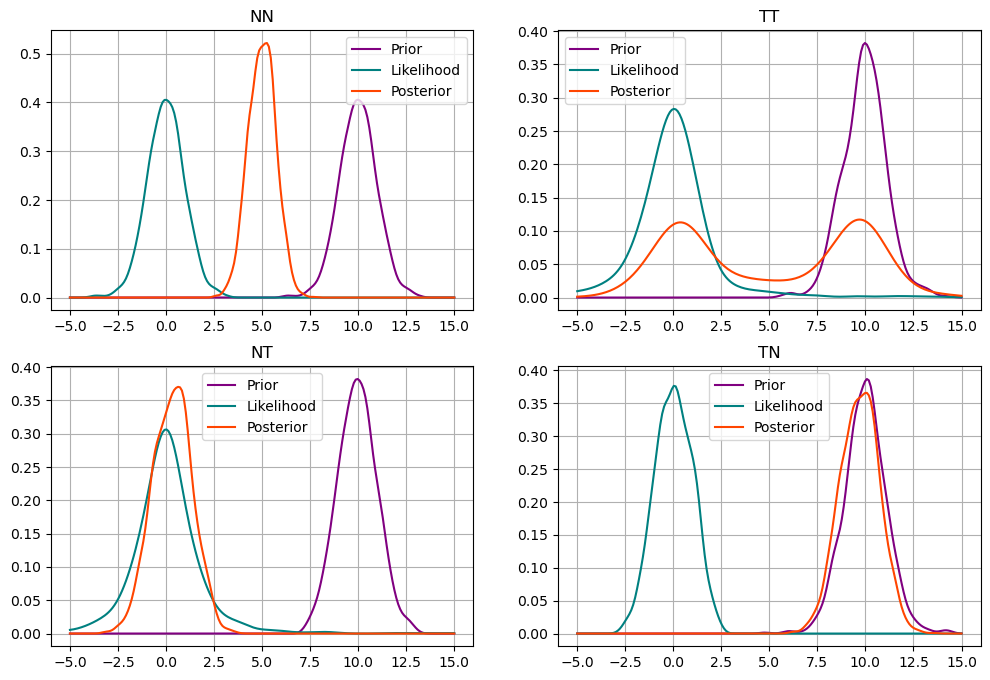

In [85]:
plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Increase the figsize for the subplots
axs = axs.flatten()

for i in range(len(models)):

    # in which subplot to plot
    ax = axs[i]

    # get prior and likelihood
    prior = models[i]['prior']
    likelihood = models[i]['likelihood']

    # sampling
    rng_key = jax.random.PRNGKey(0)
    model = models[i]['model']
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=1, progress_bar=False)
    mcmc.run(rng_key, jnp.array(yobs))
    posterior_samples = mcmc.get_samples()['mu']

    # visualise
    prior_likelihood_posterior(prior, likelihood, posterior_samples, ax, ttl=models[i]['model_name'], rng_i=i)

#plt.tight_layout()
plt.show()